# Feature Engineering

Goals:
- To create features that are independent of the dataset space, hoping to transfer knowledg across different feature space profiles.

Potential features:
- Mean/Median of pressures
- Mean/Median of transducer locations
- Dimensions of the isolator tunnel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
umich = pd.read_csv('../data/umich.csv', index_col = 0 )

In [3]:
runs = umich['Run'].unique()
variables = {}

# Loop through a range of values
for i in runs:
    # Create a new variable name
    variable_name = f"{i}"
    
    # Create a new variable value
    variable_value = umich[umich['Run']==i]
    
    # Assign the variable value to the variable name in the dictionary
    variables[variable_name] = variable_value.reset_index(drop=True)

for variable_name, variable_value in variables.items():
    globals()[variable_name] = variable_value
    
df_list = [R0, R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11,
           R12, R13, R14, R15, R17, R18, R19, R20, R21,
           R22, R23, R24, R25, R26, R27, R28, R29, R30, R31,
           R32, R33, R34, R35, R36, R37] # Note: R16 is dropped because of NaN values.

pressure_transducers = ['p1','p2','p3','p4','p5']
location_list = ['px1','px2','px3','px4','px5']

---

# TRAINING ON A SINGLE RUN

In [4]:
def aggregate_features(df):
    df = df.copy()
    original_columns = df.columns
    
    df['mean_press'] = df[['p1','p2','p3','p4','p5']].mean(axis=1)
    df['median_press'] = df[['p1','p2','p3','p4','p5']].median(axis=1)
    df['std_press'] = df[['p1','p2','p3','p4','p5']].std(axis=1)
    df['var_press'] = df[['p1','p2','p3','p4','p5']].var(axis=1)
    df['q1_press'] = df[['p1','p2','p3','p4','p5']].quantile(0.25,axis=1)
    df['q3_press'] = df[['p1','p2','p3','p4','p5']].quantile(0.75,axis=1)
    df['max_press'] = df[['p1','p2','p3','p4','p5']].max(axis=1)
    df['min_press'] = df[['p1','p2','p3','p4','p5']].min(axis=1)
    #df['rolling_mean_press'] = df['mean_press'].rolling(300).mean()
    #df['rolling_median_press'] = df['mean_press'].rolling(300).mean()
    #df['rolling_std_press'] = df['mean_press'].rolling(300).std()

    
    #Original feature (first and last transducers)
    #df['p1_rolled_mean']=df['p1'].rolling(300).mean()
    #df['p5_rolled_mean'] = df['p5'].rolling(300).mean()
    #df['p1_rolled_median']=df['p1'].rolling(300).median()
    #df['p5_rolled_median'] = df['p5'].rolling(300).median()
    #df['p1_rolled_std']=df['p1'].rolling(300).std()
    #df['p5_rolled_std'] = df['p5'].rolling(300).std()
    #df['p1_'] = df['p1']
    #df['p1_mean'] = df['p1'].mean()
    #df['p1_median'] = df['p1'].median()
    #df['p1_std'] = df['p1'].std()
    #df['p5_'] = df['p5']
    #df['p5_mean'] = df['p5'].mean()
    #df['p5_median'] = df['p5'].median()
    #df['p5_std'] = df['p5'].std()

    y = df['x1']
    X = df.drop(original_columns,axis=1)
    return X, y, df

In [5]:
def split_data(X,y):
    half_instance = len(X)//2
    X_train = X.iloc[:half_instance]
    X_test = X.iloc[half_instance:]
    y_train = y.iloc[:half_instance]
    y_test = y.iloc[half_instance:]
    
    return X_train, y_train, X_test, y_test

In [6]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler

In [7]:
X,y,df = aggregate_features(R17)

In [8]:
X_train, y_train, X_test, y_test = split_data(X,y)

In [9]:
lin_reg = LinearRegression()

In [10]:
lin_reg.fit(X_train,y_train)

LinearRegression()

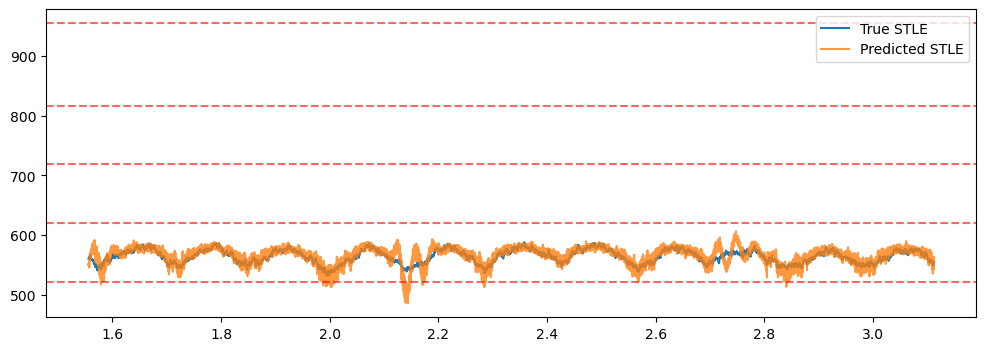

In [11]:
plt.figure(figsize=(12,4))
plt.plot(df['time'].iloc[len(y_test)-1:], y_test,label='True STLE')
plt.plot(df['time'].iloc[len(y_test)-1:], lin_reg.predict(X_test),alpha=0.8,label='Predicted STLE')

for i in range(5):
    plt.axhline(df['px'+str(i+1)].iloc[0], color='red',ls='--',alpha=0.6)

plt.legend()
plt.show()

---

# DNN ON MULTIPLE RUNS

Goals:
- To achieve a model that generalizes to different runs
- To attempt various methods to find a universal model

Train Runs:
- Single Damp: R0, R7 
- Three Damps: R8, R19, R21, 
- Greater than 3 Damps: R2, R3, R4, R5, R6, R9, R10, R11, R23
- Difficult Ocillations: R12, R13, R14, R15
- Symmetry Transducers (?): R32, R33, R34, R35
- Near Constant Pressure Movement: R24, R27

Test Runs:
- Single Damp: R22, 
- Three Damps: R1, R20
- Greater than 3 Damps: R25, R26, R28, R29, R31, 
- Difficult Ocillations: R17, R18, 
- Symmetry Transducers (?): R36, R37
- Near Constant Pressure Movement: R30

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [13]:
X,y,df = aggregate_features(umich)

In [14]:
X['Run'] = df['Run']
X['x1'] = y

In [15]:
train_run = ['R0','R8','R2','R12','R32','R24','R36','R14','R33',
            'R28','R29','R30','R31','R37','R21','R6','R9','R10']

test_run = ['R11','R23','R35','R27','R13','R15','R20','R1','R3','R4','R5','R7','R17','R18','R19','R22','R25','R26']

In [16]:
train_set = X[X['Run'].isin(train_run)]
test_set = X[X['Run'].isin(test_run)]
df_train = df[df['Run'].isin(train_run)]
df_test = df[df['Run'].isin(test_run)]

In [17]:
train_set['H'] = 57.15
train_set['W'] = 69.85
test_set['H'] = 57.15
test_set['W'] = 69.85

In [18]:
train_set = train_set.iloc[300:]
test_set = test_set.iloc[300:]

In [19]:
def RunNeuralNet(train_df, test_df):
    X_train = train_df.drop(['x1','Run'],axis=1)
    X_test = test_df.drop(['x1','Run'],axis=1)
    y_train = train_df['x1']
    y_test = test_df['x1']

    ss = StandardScaler()

    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    model = Sequential()
    model.add(Dense(20, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))


    model.add(Dense(1))

    model.compile(optimizer='adam',loss='mae')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
    
    model.fit(x=X_train_scaled,y=y_train.values,
          validation_data=(X_test_scaled,y_test.values),
          batch_size=128,epochs=100,callbacks=[early_stopping])
    
    y_pred = model.predict(X_test_scaled)
    test_df = test_df.copy()
    test_df['pred'] = y_pred
    
    return test_df,model

In [20]:
result, model = RunNeuralNet(train_set, test_set)

Epoch 1/100
4375/4375 [==============================] - 3s 661us/step - loss: 46.3541 - val_loss: 7.0637
Epoch 2/100
4375/4375 [==============================] - 3s 643us/step - loss: 6.4406 - val_loss: 5.7031
Epoch 3/100
4375/4375 [==============================] - 3s 642us/step - loss: 5.6224 - val_loss: 5.3326
Epoch 4/100
4375/4375 [==============================] - 3s 643us/step - loss: 5.2963 - val_loss: 4.9427
Epoch 5/100
4375/4375 [==============================] - 3s 642us/step - loss: 5.1212 - val_loss: 5.1081
Epoch 6/100
4375/4375 [==============================] - 3s 641us/step - loss: 5.0177 - val_loss: 5.3082
Epoch 7/100
4375/4375 [==============================] - 3s 642us/step - loss: 4.9494 - val_loss: 5.3752
Epoch 8/100
4375/4375 [==============================] - 3s 642us/step - loss: 4.9006 - val_loss: 5.0584
Epoch 9/100
4375/4375 [==============================] - 3s 641us/step - loss: 4.8712 - val_loss: 5.2363
Epoch 9: early stopping
17498/17498 [=================

In [21]:
result['time'] = df_test['time']

In [22]:
df_test['Run'] = result['Run']

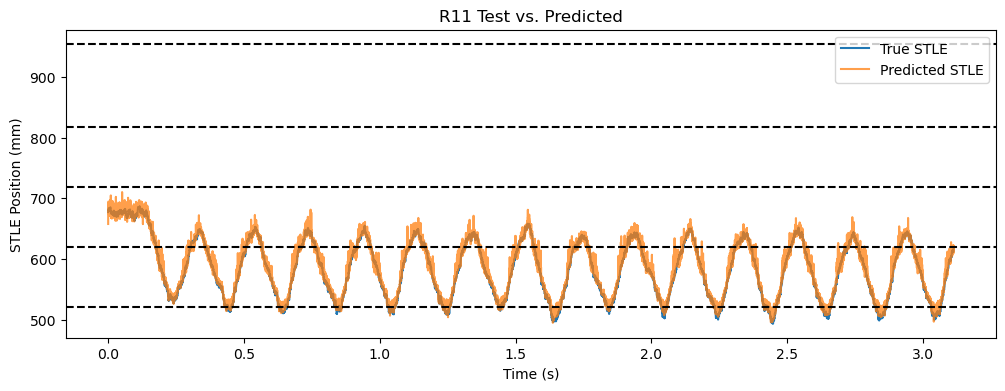

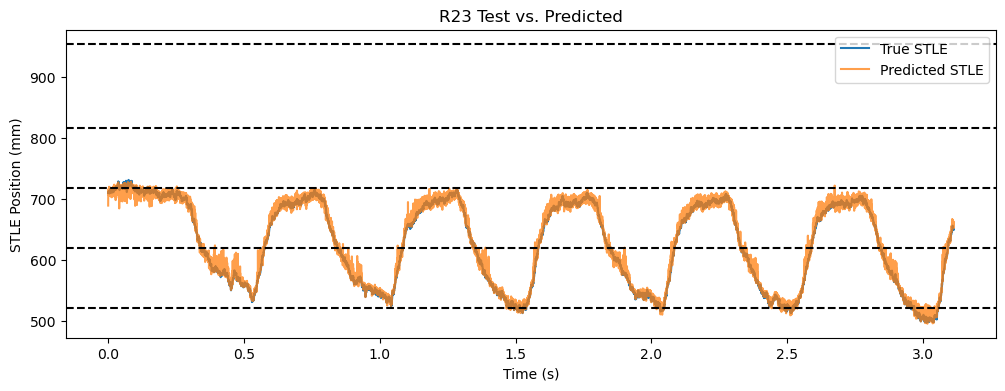

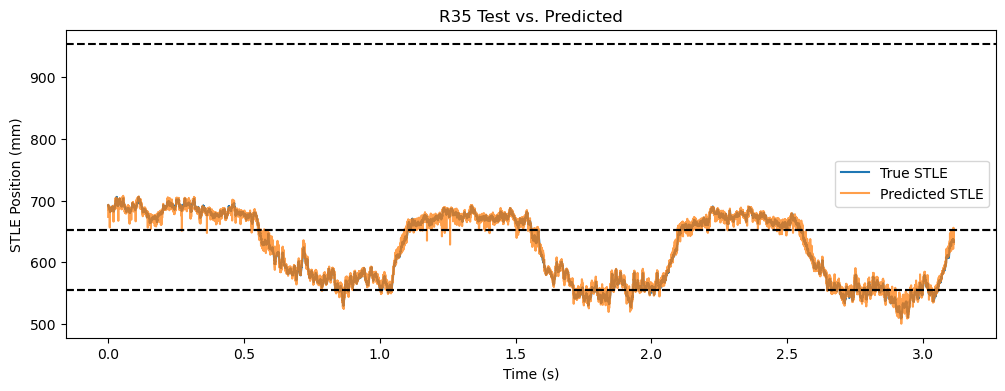

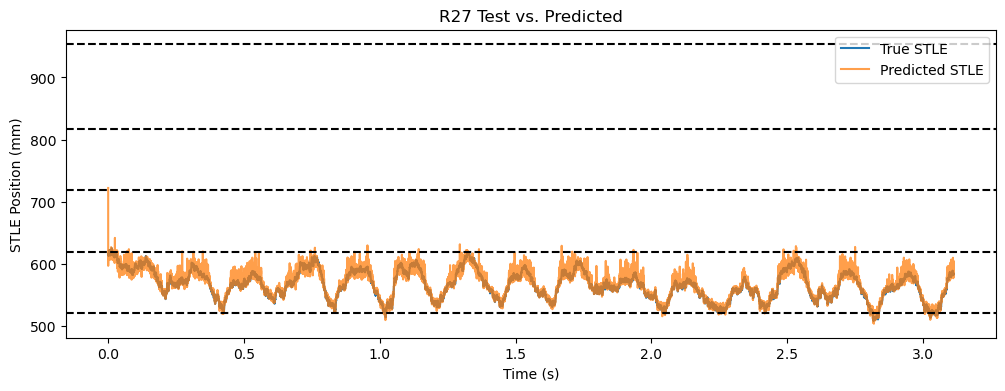

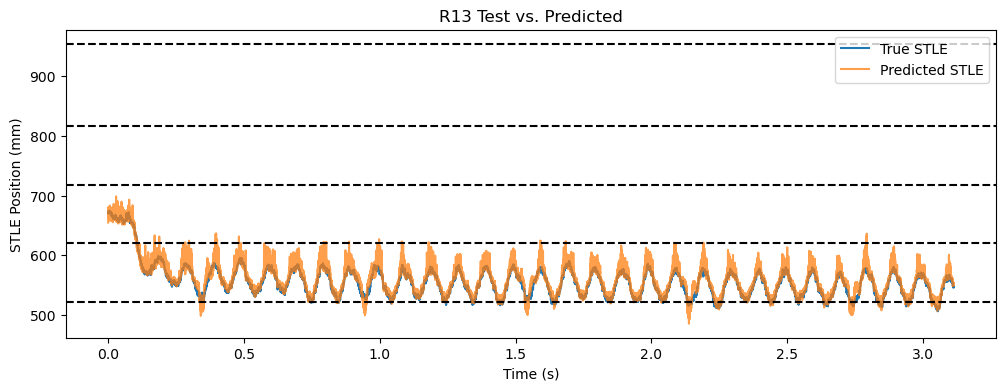

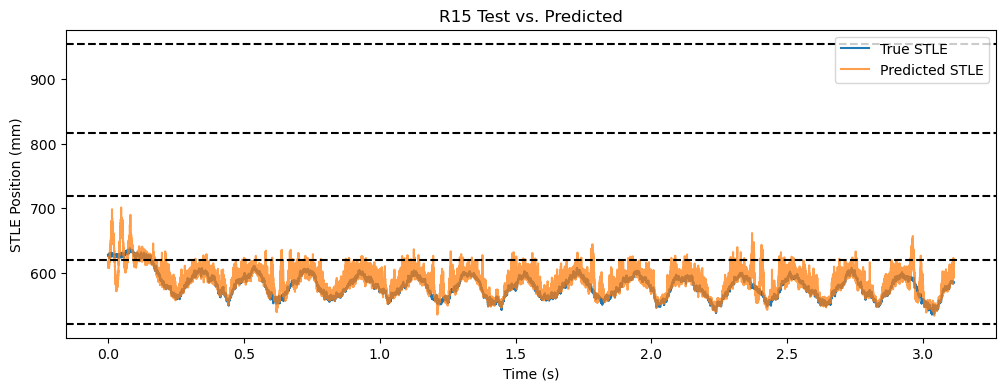

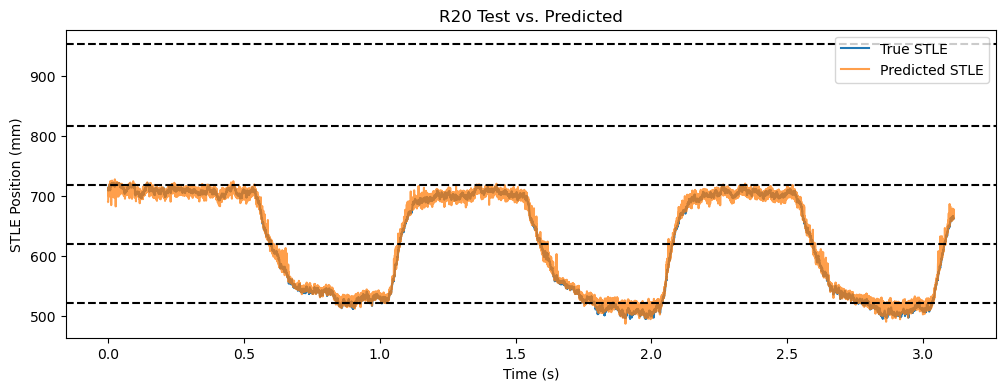

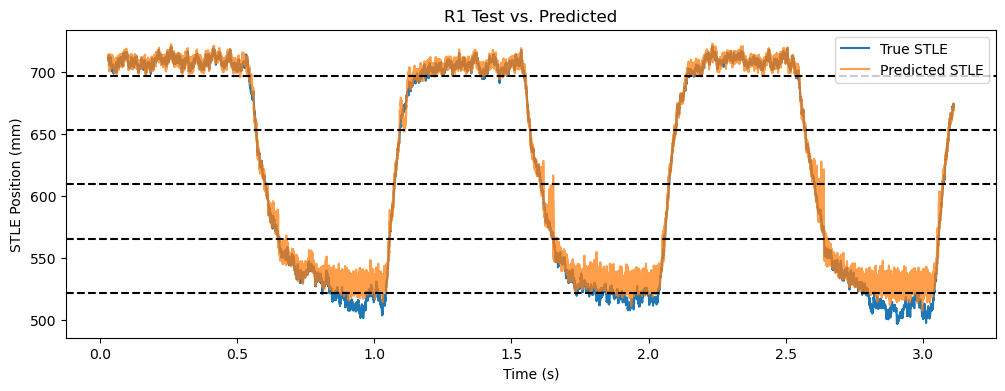

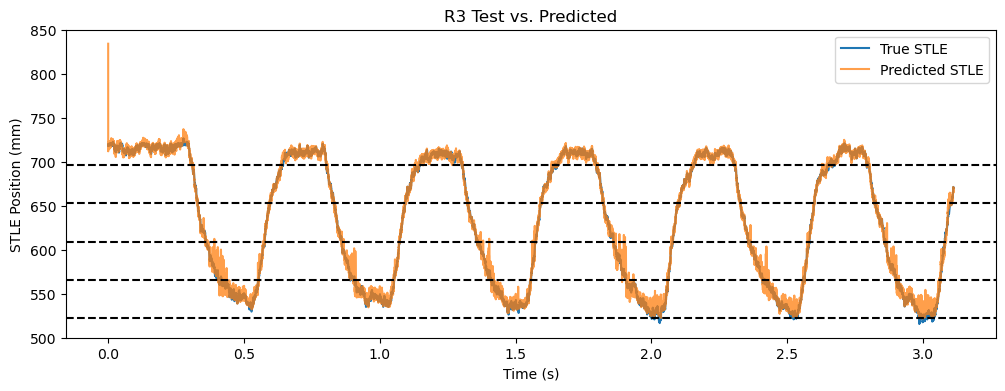

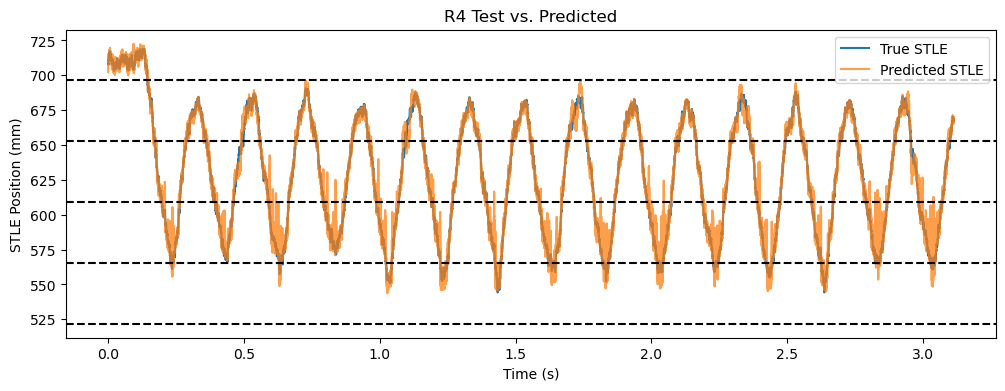

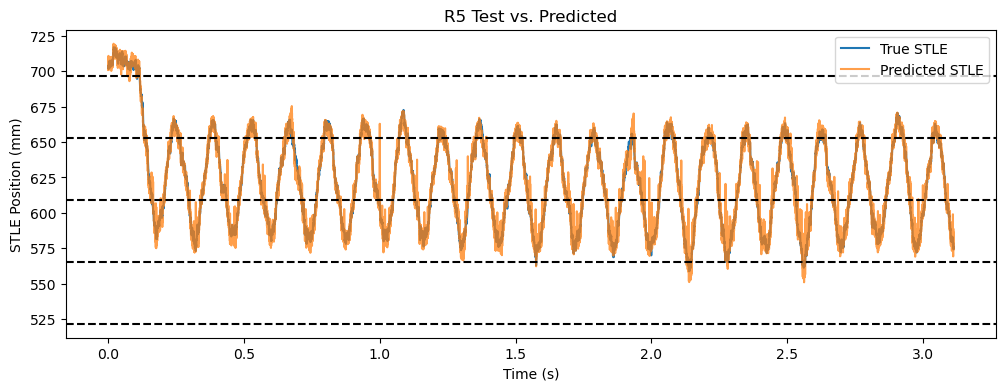

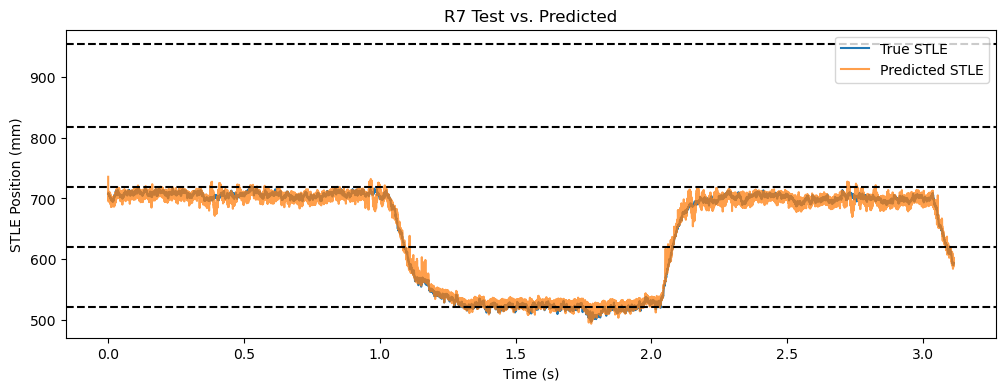

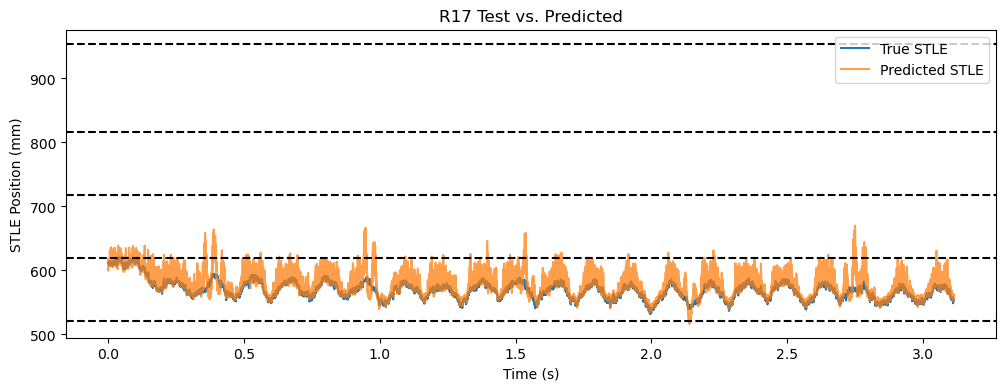

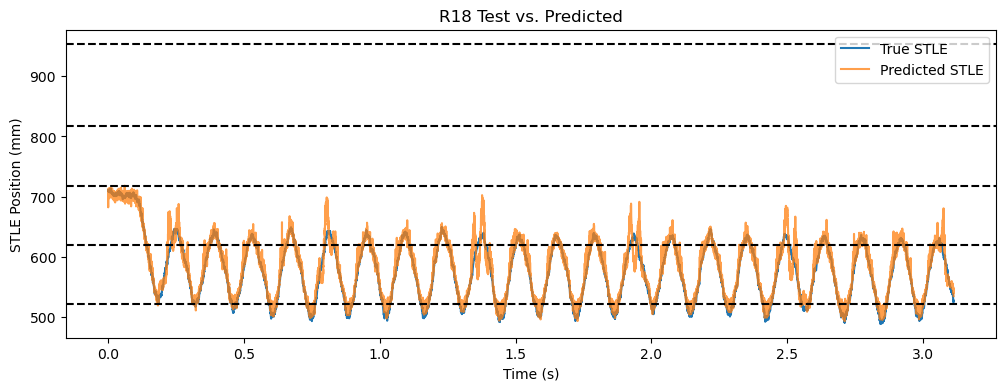

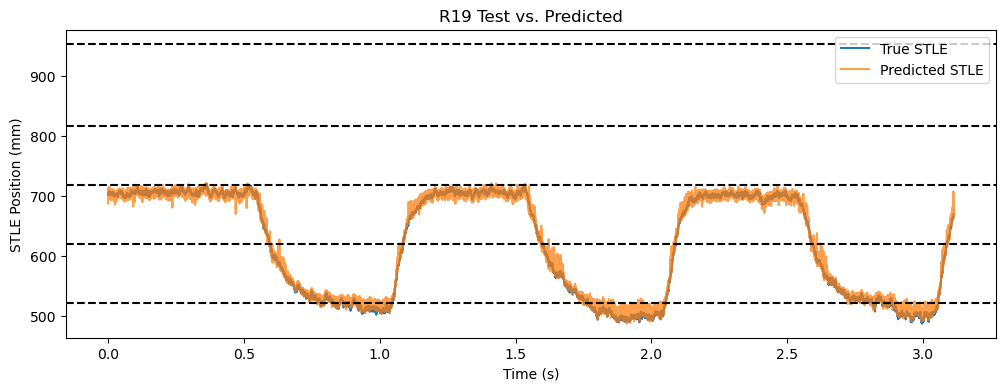

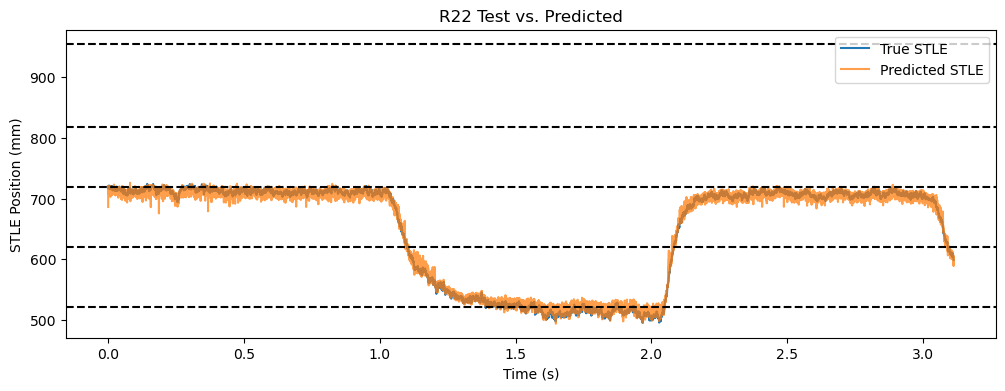

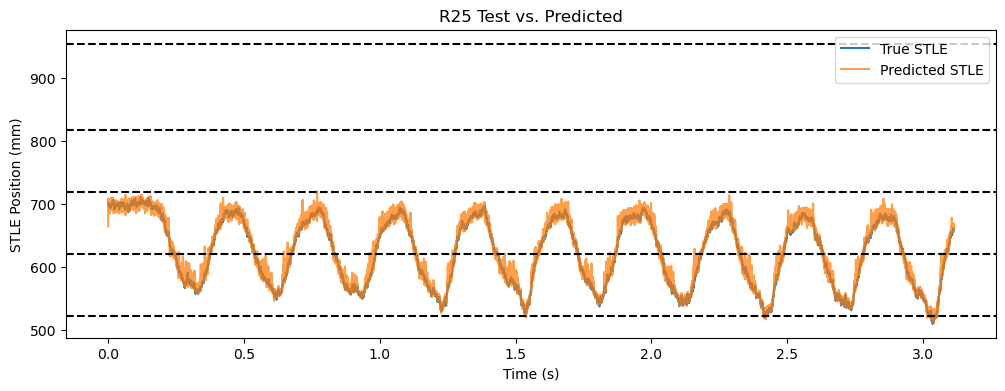

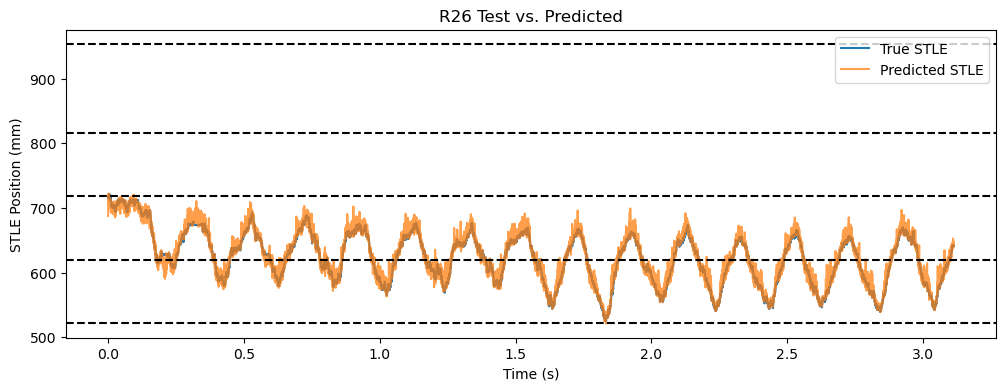

In [23]:
for i in test_run:
    result_subset = result[result['Run'] == i]
    plt.figure(figsize=(12,4))
    plt.plot(result_subset['time'], result_subset['x1'],label='True STLE')
    plt.plot(result_subset['time'], result_subset['pred'],label='Predicted STLE',alpha=0.75)
    plt.xlabel('Time (s)')
    plt.ylabel('STLE Position (mm)')
    plt.legend()
    for j in location_list:
        plt.axhline(y=df_test[df_test['Run']==i][j].iloc[0], color='black', linestyle='--')
        
    plt.title(f"{i}" + ' Test vs. Predicted')
    plt.show()

In [24]:
model.save('FEATURE_ENGINEERED_MODEL_27_FEATURES_v2')

INFO:tensorflow:Assets written to: FEATURE_ENGINEERED_MODEL_27_FEATURES_v2/assets


INFO:tensorflow:Assets written to: FEATURE_ENGINEERED_MODEL_27_FEATURES_v2/assets


# PREDICTING AFIT WITH AGGREGATED DATA

In [66]:
afit = pd.read_csv('../data/afit.csv',index_col=0)

In [67]:
#afit[['p1', 'p2', 'p3', 'p4', 'p5', 'p6',
       #'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14']]

In [68]:
def aggregate_features_afit(df,window_size=300):
    df = df.copy()
    original_columns = df.columns    
    df['mean_press'] = df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].mean(axis=1)
    df['median_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].median(axis=1)
    df['std_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].std(axis=1)
    df['var_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].var(axis=1)
    df['q1_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].quantile(0.25,axis=1)
    df['q3_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].quantile(0.75,axis=1)
    df['max_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].max(axis=1)
    df['min_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].min(axis=1)
    
    
    #df['rolling_mean_press'] = df['mean_press'].rolling(window_size).mean()
    #df['rolling_median_press'] = df['mean_press'].rolling(window_size).mean()
    #df['rolling_std_press'] = df['mean_press'].rolling(window_size).std()

    
    #Original feature (first and last transducers)
    #df['p1_rolled_mean']=df['p7'].rolling(window_size).mean()
    #df['p5_rolled_mean'] = df['p11'].rolling(window_size).mean()
    #df['p1_rolled_median']=df['p7'].rolling(window_size).median()
    #df['p5_rolled_median'] = df['p11'].rolling(window_size).median()
    #df['p1_rolled_std']=df['p7'].rolling(window_size).std()
    #df['p5_rolled_std'] = df['p11'].rolling(window_size).std()
    #df['p1_'] = df['p7']
    #df['p1_mean'] = df['p7'].mean()
    #df['p1_median'] = df['p7'].median()
    #df['p1_std'] = df['p7'].std()
    #df['p14_'] = df['p11']
    #df['p14_mean'] = df['p11'].mean()
    #df['p14_median'] = df['p11'].median()
    #df['p14_std'] = df['p11'].std()

    y = df['x1']
    X = df.drop(original_columns,axis=1)
    return X, y, df

In [69]:
X,y,afit_df = aggregate_features_afit(afit,window_size=300)

In [70]:
X['Run'] = afit_df['Run']
X['x1'] = y

In [71]:
train_runs_afit = ['R8']
test_runs_afit = ['R6','R7']

In [72]:
train_set = X[X['Run'].isin(train_runs_afit)]
test_set = X[X['Run'].isin(test_runs_afit)]
df_train = df[df['Run'].isin(train_runs_afit)]
df_test = df[df['Run'].isin(test_runs_afit)]

In [73]:
train_set['H'] = 63.5
train_set['W'] = 63.5
test_set['H'] = 63.5
test_set['W'] = 63.5

In [74]:
X_train = train_set.drop(['Run','x1'],axis=1)
X_test = test_set.drop(['Run','x1'],axis=1)
y_train = train_set['x1']
y_test = test_set['x1']

In [75]:
from tensorflow.keras.models import load_model

In [76]:
base_model = load_model('FEATURE_ENGINEERED_MODEL_27_FEATURES')

In [77]:
new_model = Sequential()

base_model.trainable = False
    
new_model.add(base_model)

new_model.add(Dense(20, activation='relu'))
new_model.add(Dense(30, activation='linear'))
new_model.add(Dense(10, activation='relu'))

new_model.add(Dense(1))
              
new_model.compile(optimizer='adam',loss='mae')

In [78]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1)

In [79]:
result = new_model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=300, callbacks=[early_stopping])

Epoch 1/300
47/47 [==============================] - 0s 2ms/step - loss: 31.5642 - val_loss: 16.6937
Epoch 2/300
47/47 [==============================] - 0s 1ms/step - loss: 24.2955 - val_loss: 5.2989
Epoch 3/300
47/47 [==============================] - 0s 1ms/step - loss: 23.9428 - val_loss: 21.6170
Epoch 4/300
47/47 [==============================] - 0s 1ms/step - loss: 23.3770 - val_loss: 35.0458
Epoch 5/300
47/47 [==============================] - 0s 1ms/step - loss: 23.1707 - val_loss: 38.3771
Epoch 6/300
47/47 [==============================] - 0s 1ms/step - loss: 23.3110 - val_loss: 26.8128
Epoch 7/300
47/47 [==============================] - 0s 1ms/step - loss: 23.5486 - val_loss: 3.0296
Epoch 8/300
47/47 [==============================] - 0s 1ms/step - loss: 23.0278 - val_loss: 13.6011
Epoch 9/300
47/47 [==============================] - 0s 1ms/step - loss: 22.7679 - val_loss: 17.1925
Epoch 10/300
47/47 [==============================] - 0s 1ms/step - loss: 22.9097 - val_loss:

<Axes: >

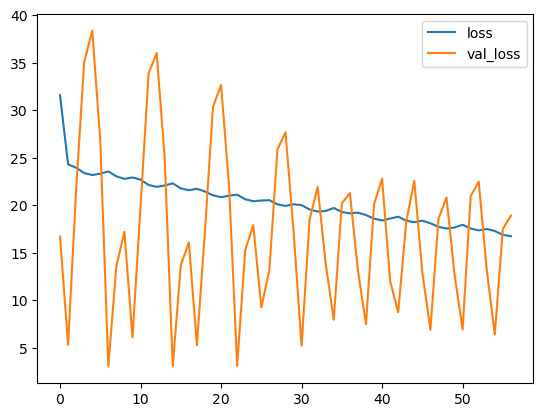

In [80]:
pd.DataFrame(result.history).plot()

In [81]:
y_pred = new_model.predict(X_test)

409/409 [==============================] - 0s 370us/step


In [82]:
test_set['pred'] = y_pred

In [83]:
afit_df.columns

Index(['px1', 'px2', 'px3', 'px4', 'px5', 'px6', 'px7', 'px8', 'px9', 'px10',
       'px11', 'px12', 'px13', 'px14', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6',
       'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'x1', 'Run',
       'time', 'H', 'W', 'L', 'mean_press', 'median_press', 'std_press',
       'var_press', 'q1_press', 'q3_press', 'max_press', 'min_press'],
      dtype='object')

In [84]:
location_list_afit = ['px1', 'px2', 'px3', 'px4', 'px5', 'px6', 'px7', 'px8', 'px9', 'px10',
       'px11', 'px12', 'px13', 'px14']

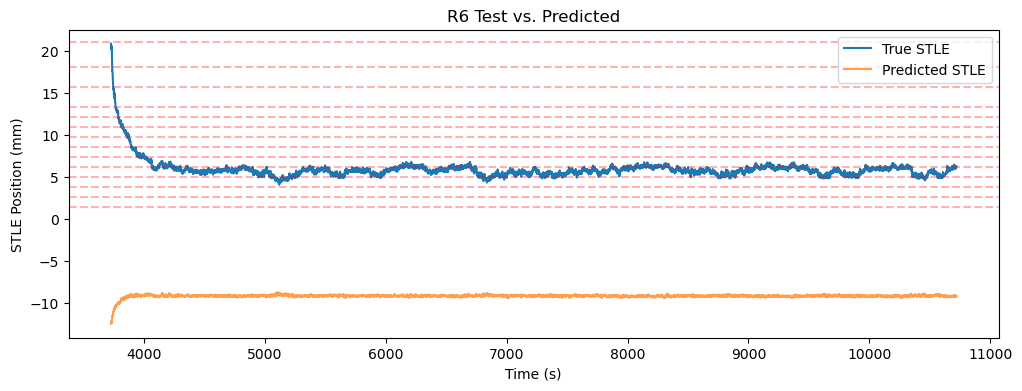

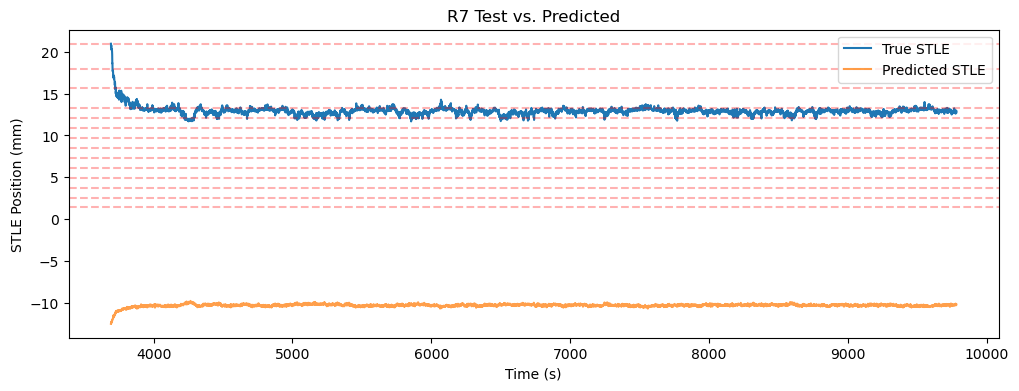

In [85]:
for i in test_runs_afit:
    result_subset = test_set[test_set['Run'] == i]
    plt.figure(figsize=(12,4))
    plt.plot(result_subset['x1'],label='True STLE')
    plt.plot(result_subset['pred'],label='Predicted STLE',alpha=0.75)
    plt.xlabel('Time (s)')
    plt.ylabel('STLE Position (mm)')
    plt.legend()
    for j in location_list_afit:
        plt.axhline(y=afit[afit['Run']==i][j].iloc[0], color='red', linestyle='--',alpha=0.3)
        
    plt.title(f"{i}" + ' Test vs. Predicted')
    plt.show()